# Compute the MAP for these shot detect videos

In [4]:
import pandas as pd
import sys, numpy as np
sys.path.append("/afs/cs.stanford.edu/u/anenberg/scr/caffe/python/")
import caffe
import lmdb


# location of the list that was used to create LMDB for training/testing
test_list = '../../data/allFrames/lists/fullpath_shuffle_shotdetect_sampled_100_test_list.txt'

N = 155293 # the number of test examples
num_classes = 101 # the number of classes

In [5]:
!wc $test_list

  155293   310586 15360458 ../../data/allFrames/lists/fullpath_shuffle_shotdetect_sampled_100_test_list.txt


# Get the labels from the list

In [6]:
def get_label_from_list(list_filename):
    df = pd.read_csv(list_filename, delimiter= ' ', header = None, names = ['filename', 'class_id'])
    return df

df =  get_label_from_list(test_list)
labels = df.class_id.values
df['video_name'] = df.filename.apply(lambda x: x.split('/')[-2])

# Map the video to the labels

In [7]:
# map the videos to the labels
video_to_labels = list(set(zip(df.video_name, df.class_id)))
video_to_labels = pd.DataFrame(data=[l[1] for l in video_to_labels], index=[l[0] for l in video_to_labels], columns=['true_labels'])

In [8]:
categories = pd.read_csv('/afs/cs.stanford.edu/group/cvgl/rawdata/THUMOS2014/Training/ucfTrainTestlist/classInd.txt', delimiter=' ', header=None, names=['label', 'category'])
categories.label -= 1
categories = {k: v for k, v in zip(categories.label.values, categories.category.values)}

In [9]:
len(video_to_labels)

1568

# Extract features using the extract_features binary

In [11]:
!./extract.sh 

E0314 14:48:09.131742 29300 extract_features.cpp:54] Using GPU
E0314 14:48:09.132372 29300 extract_features.cpp:60] Using Device_id=1
E0314 14:48:10.964857 29300 upgrade_proto.cpp:618] Attempting to upgrade input file specified using deprecated V1LayerParameter: ./quick_train_test.prototxt
E0314 14:48:14.778620 29300 extract_features.cpp:134] Extacting Features
E0314 14:48:56.998111 29300 extract_features.cpp:169] Extracted features of 1000 query images for feature blob fc8_allFrames
E0314 14:49:40.493867 29300 extract_features.cpp:169] Extracted features of 2000 query images for feature blob fc8_allFrames
E0314 14:50:20.288388 29300 extract_features.cpp:169] Extracted features of 3000 query images for feature blob fc8_allFrames
E0314 14:51:05.937664 29300 extract_features.cpp:169] Extracted features of 4000 query images for feature blob fc8_allFrames
E0314 14:51:48.132640 29300 extract_features.cpp:169] Extracted features of 5000 query images for feature blob fc8_allFrames
E0314 14:52

## Open and extract the data from the LMDB

In [13]:
env = lmdb.open('./extracted/features2', readonly=True)

predicted_labels = [] # for a particular image, this will be the argmax for the scores
data = np.zeros((N, num_classes)) # collect the scores for each image for each class

with env.begin() as txn:
    with txn.cursor() as cursor:
        for i in range(N):
            key = str(i)
            val = cursor.get(key)
            datum = caffe.proto.caffe_pb2.Datum()
            datum.ParseFromString(val)
            # datum.ListFields()[3][1] contains the scores
            data[i, :] = np.array(list(datum.ListFields()[3][1]))
            predicted_labels.append(np.argmax(np.array(list(datum.ListFields()[3][1]))))


# create the normalized dataframe

In [14]:
normalized_data = np.exp(data)/sum(np.exp(data))
normalized_data = pd.DataFrame(normalized_data)

# average the probabilities across videos

In [15]:
normalized_data['video_name'] = df['video_name']
normalized_data = normalized_data.groupby('video_name').mean()


In [16]:
normalized_data['predicted_label'] = np.argmax(normalized_data.values, axis = 1)
normalized_data['true_label'] = video_to_labels

# Compute the average precision

In [17]:
dfs = []

def compute_average_precision(normalized_data, class_id):
    # given a class_id compute the average precision for that class
    df = normalized_data[[class_id, 'true_label', 'predicted_label']]
    df = df.sort(class_id, ascending=False)
    df['match'] = (df.true_label == class_id)
    df['precision'] = np.cumsum(df.match)/np.arange(1, len(normalized_data) + 1)
    df['recall'] = np.cumsum(df.match)/np.sum(df.true_label == class_id)
    df['delta_recall'] = np.diff(np.append([0], df.recall.values))
    df['rect_area'] = df['precision'] * df['delta_recall']
    dfs.append(df.copy())
    return sum(df.rect_area)

average_precision = [] # list to hold average_precision

for class_id in range(num_classes):
    ca = compute_average_precision(normalized_data, class_id)
    average_precision.append(ca)
    
average_precision = [x if not np.isnan(x) else 0 for x in average_precision]
labels_as_text = [categories[i] for i in range(101)]

In [18]:
bar_chart_df = pd.DataFrame(average_precision, columns= ['ap'], index=labels_as_text)
bar_chart_df = bar_chart_df.sort('ap')

Populating the interactive namespace from numpy and matplotlib


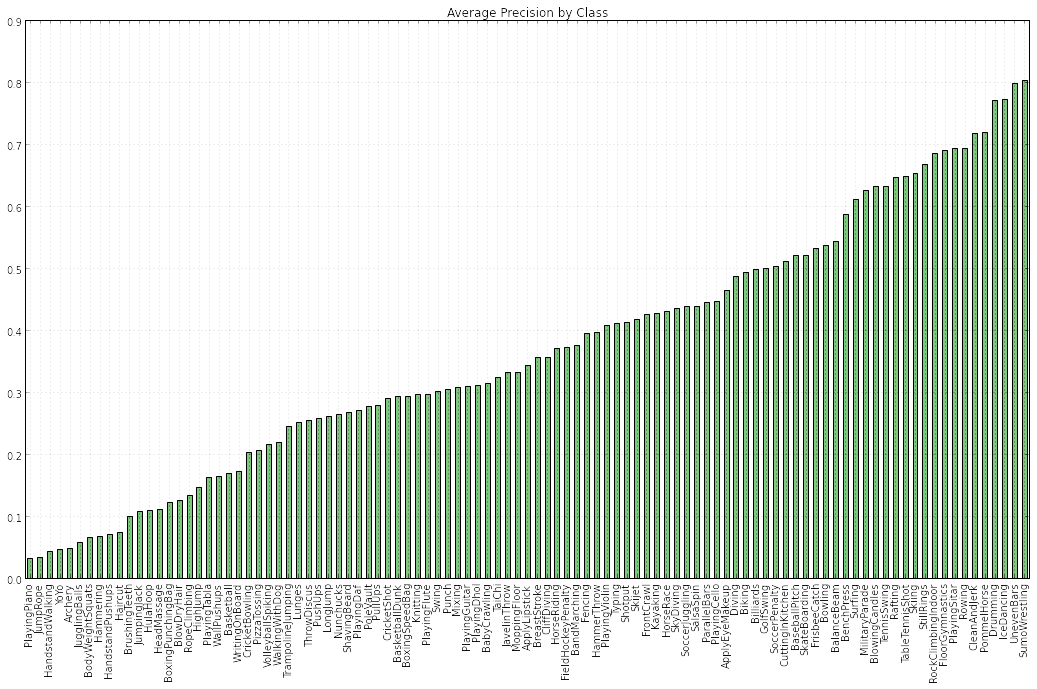

In [24]:
%pylab inline
import matplotlib
bar_chart_df[::].plot(kind='bar', figsize=(18, 10), legend = False, colormap=matplotlib.cm.Accent, title='Average Precision by Class')

Populating the interactive namespace from numpy and matplotlib


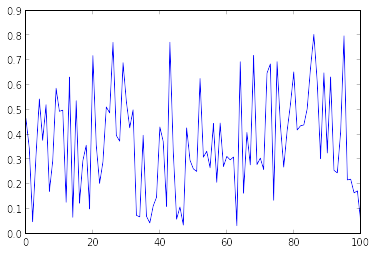

In [20]:
%pylab inline
plt.plot(average_precision)

In [21]:
np.mean(average_precision)

0.36907930698653152

In [22]:
da

array([[-6.54149342, -2.27000523,  1.60427606, ...,  3.85092282,
        -0.69594562, -1.01029515],
       [-4.94216633,  1.44821274,  1.76429415, ...,  0.66380459,
        -4.65897226,  2.09863329],
       [-1.74665236, -1.24111152, -0.72320271, ...,  7.89236879,
        -3.38204193,  2.39770913],
       ..., 
       [-4.72923517, -3.41327214,  2.20128202, ..., -0.49361619,
        -3.64147258,  0.88705707],
       [-0.2289668 ,  0.16615999,  0.9039799 , ...,  1.8536737 ,
         5.76294613,  0.73786056],
       [-1.30967128, -1.48037279, -1.03675938, ...,  2.96748376,
         5.7075057 ,  0.17046538]])

In [30]:
# Create confusion matrix
# Compute confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(normalized_data.true_label, normalized_data.predicted_label)

# Show confusion matrix in a separate window
plt.figure(figsize=(12, 12))
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


/usr/local/lib/python2.7/dist-packages/sklearn/utils/multiclass.py:194: DeprecationWarning: Direct support for sequence of sequences multilabel representation will be unavailable from version 0.17. Use sklearn.preprocessing.MultiLabelBinarizer to convert to a label indicator representation.
  DeprecationWarning)


ValueError: Can't handle mix of multilabel-sequences and multiclass

#Normalize scores to compute average precision for each class

In [42]:
print 'MAP: %2f'%np.mean(average_precision)

MAP: nan


In [32]:
# What was the accuracy?
np.mean(normalized_data.true_label == normalized_data.predicted_label)

0.0

Populating the interactive namespace from numpy and matplotlib


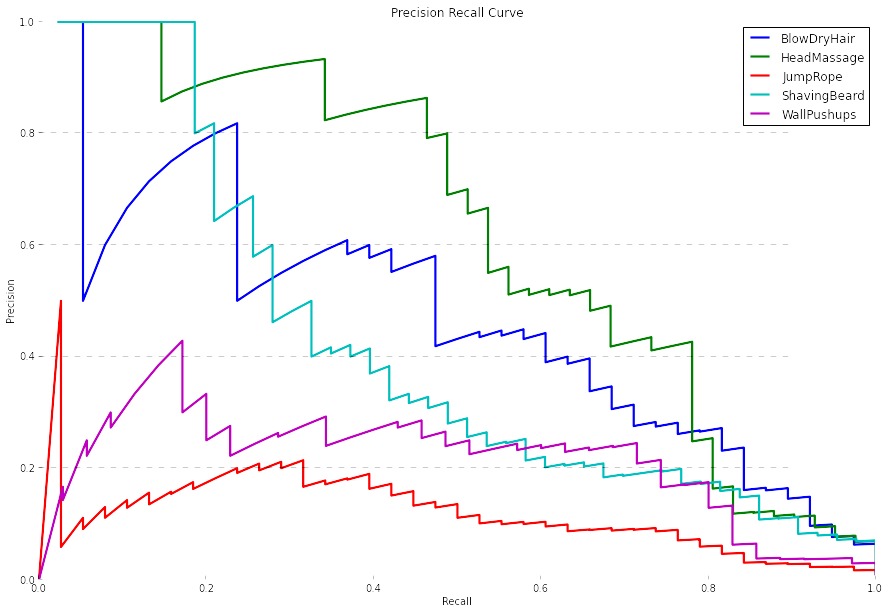

In [80]:
%pylab inline  

# These are the "Tableau 20" colors as RGB.  
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]  
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.  
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)  
  
# You typically want your plot to be ~1.33x wider than tall. This plot is a rare  
# exception because of the number of lines being plotted on it.  
# Common sizes: (10, 7.5) and (12, 9)  
figure(figsize=(15, 10))  
  
# Remove the plot frame lines. They are unnecessary chartjunk.  
ax = subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["bottom"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.spines["left"].set_visible(False) 

for class_id in [12, 38, 47, 77, 98]:
    ax.plot(dfs[class_id].recall, dfs[class_id].precision, label = categories[class_id], lw=2.5)

    
# Provide tick lines across the plot to help your viewers trace along  
# the axis ticks. Make sure that the lines are light and small so they  
# don't obscure the primary data lines.  
for y in np.arange(0, 1, .2):  
    plot(np.arange(0, 1, 0.1), [y] * len(np.arange(0, 1, 0.1)), "--", lw=0.5, color="black", alpha=0.9)  

# Ensure that the axis ticks only show up on the bottom and left of the plot.  
# Ticks on the right and top of the plot are generally unnecessary chartjunk.  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision Recall Curve')
ax.legend()

In [81]:
from caffe import draw

ImportError: No module named pydot

In [82]:
!/afs/cs.stanford.edu/u/anenberg/scr/caffe/python/draw_net.py

Traceback (most recent call last):
  File "/afs/cs.stanford.edu/u/anenberg/scr/caffe/python/draw_net.py", line 9, in <module>
    import caffe.draw
  File "/afs/cs.stanford.edu/u/anenberg/scr/caffe/python/caffe/draw.py", line 11, in <module>
    import pydot
ImportError: No module named pydot


In [22]:
np.mean(normalized_data.predicted_label == normalized_data.true_label)

0.30229591836734693